In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import time
from sklearn.metrics import f1_score
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from math import log

In [2]:
drive.mount('/content/drive/')
#改变当前工作目录到谷歌云盘的路径
path="/content/drive/My Drive/Colab Notebooks/Bias Detection/"
os.chdir(path)

Mounted at /content/drive/


In [3]:
X_train_process = np.load("X_train_glove_title.npy")
X_test_process = np.load("X_test_glove_title.npy")
X_valid_process = np.load("X_valid_glove_title.npy")
y_train_process = np.load("y_train_glove.npy")
y_test_process = np.load("y_test_glove.npy")
y_valid_process = np.load("y_valid_glove.npy")
H_train_process = np.load("X_train_glove_headline.npy")
H_test_process = np.load("X_test_glove_headline.npy")
H_valid_process = np.load("X_valid_glove_headline.npy")

In [4]:
X_train = np.concatenate([X_train_process, H_train_process], axis = 1)
X_test = np.concatenate([X_test_process, H_test_process], axis = 1)
X_valid = np.concatenate([X_valid_process, H_valid_process], axis = 1)

In [5]:
train_loader = Data.DataLoader(
    dataset=Data.TensorDataset(torch.Tensor(X_train),torch.LongTensor(y_train_process)),      
    batch_size=128,      
    shuffle=True,               
    num_workers=2, 
    drop_last=True
)
test_loader = Data.DataLoader(
    dataset=Data.TensorDataset(torch.Tensor(X_test),torch.LongTensor(y_test_process)),      
    batch_size=128,      
    shuffle=True,               
    num_workers=2,  
    drop_last=True
)
val_loader = Data.DataLoader(
    dataset=Data.TensorDataset(torch.Tensor(X_valid),torch.LongTensor(y_valid_process)),      
    batch_size=128,      
    shuffle=True,               
    num_workers=2,
    drop_last=True
)

In [6]:
def ECA(x,gamma=2,b=1):
    N,C,H,W=x.size()
    t=int(abs((log(C,2)+b)/gamma))
    k=t if t%2 else t+1
    
    avg_pool=nn.AdaptiveAvgPool2d(1).cuda()
    conv=nn.Conv1d(1,1,kernel_size=k,padding=int(k/2),bias=False).cuda()
    sigmoid=nn.Sigmoid().cuda()
    
    y=avg_pool(x)
    y=conv(y.squeeze(-1).transpose(-1,-2))
    y=y.transpose(-1,-2).unsqueeze(-1)
    y=sigmoid(y)
    return y

In [7]:
class TextRCNN(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_size,num_labels=5):
        super(TextRCNN,self).__init__()
        self.GRU = nn.GRU(input_size=embedding_dim,hidden_size=hidden_size,
                            batch_first=True,bidirectional=True)
        self.dropout = nn.Dropout(.3)
        self.linear1 = nn.Linear(embedding_dim+2*hidden_size, 128)
        self.linear2 = nn.Linear(600, 128)
        self.linear3 = nn.Linear(128, num_labels)
        self.conv1 = nn.Conv1d(in_channels=128,out_channels=600,kernel_size=6)#通过out_channel改变文中的feature map，且out_channel∈[10,50,100,200,400,600,800,1000]
        self.conv2 = nn.Conv1d(in_channels=128,out_channels=600,kernel_size=7)
        self.conv3 = nn.Conv1d(in_channels=128,out_channels=600,kernel_size=8)
        self.conv4 = nn.Conv1d(in_channels=128,out_channels=600,kernel_size=9)
        #self.w_omiga = torch.randn(128,hidden_size*2,1,requires_grad=True).cuda()

    def forward(self, x):#x: [batch,L]
        #x_embed = x.cuda()
        headline = x[:, 500:, :].cuda()
        head_hidden_state, (h_c, h_h) = self.GRU(headline)
        U = head_hidden_state[:, -1, :].unsqueeze(1)
        U = U.permute(0,2,1)
        x_embed = x[:, :500, :].cuda()
        last_hidden_state,(c,h) = self.GRU(x_embed) #last_hidden_state: [batch,L,hidden_size * num_bidirectional]
        H = torch.nn.Tanh()(last_hidden_state)
        weights=torch.nn.Softmax(dim=-1)(torch.bmm(H, U).squeeze(-1)).unsqueeze(dim=-1).repeat(1,1,2*12)  # LSTM+ATTN-Weight
        last_hidden_state=torch.mul(last_hidden_state,weights)
        out = torch.cat((last_hidden_state[:,:,:12],x_embed,last_hidden_state[:,:,12:]),2).cuda()#out: [batch,L,embedding_size + hidden_size * num_bidirectional]  
        out = F.tanh(self.linear1(out))
        out = out.permute(dims=[0,2,1]).cuda() #out: [batch,embedding_size + hidden_size * num_bidirectional,L]
        out_1 = self.conv1(out)
        out_1 = nn.ReLU()(out_1)
        out_1 = nn.MaxPool1d(kernel_size=495)(out_1)
        out_2 = self.conv1(out)
        out_2 = nn.ReLU()(out_2)
        out_2 = nn.MaxPool1d(kernel_size=494)(out_2)
        out_3 = self.conv1(out)
        out_3 = nn.ReLU()(out_3)
        out_3 = nn.MaxPool1d(kernel_size=493)(out_3)
        out_4 = self.conv1(out)
        out_4 = nn.ReLU()(out_4)
        out_4 = nn.MaxPool1d(kernel_size=492)(out_4)
        out_1 = out_1.unsqueeze(1).cuda()
        out_2 = out_2.unsqueeze(1).cuda()
        out_3 = out_3.unsqueeze(1).cuda()
        out_4 = out_4.unsqueeze(1).cuda()
        out = torch.cat([out_1, out_2, out_3, out_4],dim=1).cuda()
        channel_weights = F.softmax(ECA(out).squeeze().squeeze(),dim=1).unsqueeze(-1).unsqueeze(-1).expand_as(out)
        out = torch.mul(channel_weights,out).cuda()
        out = torch.sum(out, dim = 1)
        out = self.linear2(out.squeeze()) #out: [batch,num_labels]
        out = self.linear3(F.tanh(out))
        out = F.softmax(out,dim=1)
        return out

In [8]:
model = TextRCNN(5302,200,12).cuda()

In [9]:
loss_list, counter =[], []
count = 0
running_loss=0
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001,betas=(0.9,0.999),eps=1e-08,weight_decay=0)
total_train = 0
correct_train = 0
train_epoch, train_loss = [], []
train_acc, val_acc = [], []
avg_epoch, avg_train_loss, avg_val_acc = [], [], []
epoch_time=[]

model.train()
for epoch in range(128): 
    running_loss = 0
    total_train = 0
    correct_train = 0
    total_accuracy = 0
    total_val_accuracy = 0
    correct_val = 0
    total_val = 0   
    start1 = time.time()
    for i, data in enumerate(train_loader, 0):
        start = time.time()
        t_image, mask = data[0],torch.max(data[1],1)[1].long()
        t_image=t_image.cuda()
        optimizer.zero_grad()
        outputs = model(t_image) # forward
        ###########################################################################
        outputs=outputs.cuda()
        mask=mask.cuda()
        loss = criterion(outputs, mask.long()) # calculate the loss
        loss.backward() # back propagation
        optimizer.step() # update gradients
        running_loss += loss.item()
        
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += mask.nelement()
        correct_train += predicted.eq(mask.data).sum().item()
        train_accuracy = 100 * correct_train / total_train
        total_accuracy += train_accuracy
        if i % 5 == 0:
            end = time.time()
            print('Epoch {}:[{}/{}], Current Loss: {}, Current Training Accuracy: {}, Time: {} ms'.format(epoch+1, i, len(train_loader), loss.item(), train_accuracy, end - start))      
            train_acc.append(train_accuracy)
            train_loss.append(loss.item())
            train_epoch.append(str(epoch+1) + '/' + str(i))

            for j, data1 in enumerate(val_loader, 0):
                t_image1, mask1 = data1[0],data1[1].long()
                outputs1 = model(t_image1)
                mask1_temp=torch.max(mask1.data,1)
                mask1_temp1=mask1_temp[1].cuda()
                _, predicted1 = torch.max(outputs1.data, 1)
                total_val += mask1.nelement()
                correct_val += predicted1.eq(mask1_temp1).sum().item()
                val_accuracy= 100 * correct_val / total_val
                total_val_accuracy += val_accuracy
            val_acc.append(val_accuracy)
    end1 = time.time()
    print('Epoch {}, train Loss: {:.3f} '.format(epoch+1, running_loss/len(train_loader)), "Avg Training Accuracy: {%d %%}" % (total_accuracy/len(train_loader)), "Avg Validation Accuracy: %d %%" % (total_val_accuracy/len(val_loader)), "Epoch Time: {} ms".format(end1 - start1))
    epoch_time.append(end1-start1)
    avg_epoch.append(epoch+1)
    avg_train_loss.append(running_loss/len(train_loader))
    avg_val_acc.append(total_val_accuracy/len(val_loader))
    #print(avg_epoch)
    #print(avg_train_loss)
    #print(avg_val_acc)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 1:[0/16], Current Loss: 1.6120760440826416, Current Training Accuracy: 10.15625, Time: 4.839828729629517 ms
Epoch 1:[5/16], Current Loss: 1.4962838888168335, Current Training Accuracy: 29.296875, Time: 0.2452700138092041 ms
Epoch 1:[10/16], Current Loss: 1.5095211267471313, Current Training Accuracy: 31.74715909090909, Time: 0.24591898918151855 ms
Epoch 1:[15/16], Current Loss: 1.4342546463012695, Current Training Accuracy: 37.451171875, Time: 0.23952794075012207 ms
Epoch 1, train Loss: 1.517  Avg Training Accuracy: {30 %} Avg Validation Accuracy: 31 % Epoch Time: 11.983918190002441 ms
Epoch 2:[0/16], Current Loss: 1.4047307968139648, Current Training Accuracy: 57.8125, Time: 0.26941514015197754 ms
Epoch 2:[5/16], Current Loss: 1.3179470300674438, Current Training Accuracy: 55.338541666666664, Time: 0.2495572566986084 ms
Epoch 2:[10/16], Current Loss: 1.2961660623550415, Current Training Accuracy: 56.32102272727273, Time: 0.25290536880493164 ms
Epoch 2:[15/16], Current Loss: 1.32

In [10]:
model.eval()
pred_correct_num=[]
pred_total_num=[]
pred_result_list=[]
pred_prob_list = []
label_prob_list=[]
label_list=[]
for i, data in enumerate(test_loader, 0):
    t_image, mask = data[0],torch.max(data[1],1)[1].long()
    mask=mask.cuda()
    output_test=model(t_image)
    pred_prob_list.append(output_test)
    label_prob_list.append(data[1])
    label_list.append(mask)
    output=torch.max(output_test,1)[1].long()
    pred_result_list.append(output)
    pred_correct_num.append(output.eq(mask).sum().item())
    pred_total_num.append(output_test.shape[0])
acc_test=sum(pred_correct_num)/sum(pred_total_num)
print("The accuracy of detecting news bias: {}".format(('%.4f%%'%(acc_test*100))))

The accuracy of detecting news bias: 82.5521%


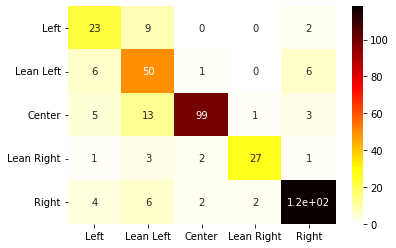

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
for i in range(len(pred_result_list)):
  if len(pred_result_list) == 1:
    pred_result = pred_result_list[0]
    label = label_list[0]
  if len(pred_result_list) == 2:
    pred_result = torch.cat((pred_result_list[0], pred_result_list[1]), -1)
    label = torch.cat((label_list[0], label_list[1]), -1)
  if len(pred_result_list) > 2:
    pred_result = torch.cat((pred_result_list[0], pred_result_list[1]), -1)
    label = torch.cat((label_list[0], label_list[1]), -1)
    for j in range(len(pred_result_list)-2):
      pred_result = torch.cat((pred_result, pred_result_list[j+2]), -1)
      label = torch.cat((label, label_list[j+2]), -1)
label = label.cpu()
pred_result = pred_result.cpu()
C=confusion_matrix(label,pred_result)
df=pd.DataFrame(C,index=["Left","Lean Left","Center","Lean Right","Right"],columns=["Left","Lean Left","Center","Lean Right","Right"])
p1=sns.heatmap(df,annot=True,cmap="hot_r")
s1 = p1.get_figure()

In [12]:
for i in range(len(pred_prob_list)):
  if len(pred_prob_list) == 1:
    pred_prob = pred_prob_list[0]
    label_prob = label_prob_list[0]
  if len(pred_prob_list) == 2:
    pred_prob = torch.cat((pred_prob_list[0], pred_prob_list[1]), -1)
    label_prob = torch.cat((label_prob_list[0], label_prob_list[1]), -1)
  if len(pred_prob_list) > 2:
    pred_prob = torch.cat((pred_prob_list[0], pred_prob_list[1]), -1)
    label_prob = torch.cat((label_prob_list[0], label_prob_list[1]), -1)
    for j in range(len(pred_prob_list)-2):
      pred_prob = torch.cat((pred_prob, pred_prob_list[j+2]), -1)
      label_prob = torch.cat((label_prob, label_prob_list[j+2]), -1)
label_prob = label_prob.cpu()
pred_prob = pred_prob.cpu()
criterion=nn.L1Loss(reduction="mean")
loss=criterion(pred_prob, label_prob)
print("MAE Value: {}".format("%.4f" % loss))

MAE Value: 0.0713


In [13]:
import numpy as np
from sklearn.metrics import f1_score
f1_score = f1_score(pred_result,label,average="macro")
print("Macro-F1 Score: {}".format("%.4f" % f1_score))

Macro-F1 Score: 0.7898
